In [11]:
import pickle
import torch
import os
import matplotlib.pyplot as plt
from src.utils.paths import get_path
from src.utils.utils import CPU_Unpickler
from pathlib import Path
from src.dataset.dataset import EventDataset
import numpy as np
from dotenv import load_dotenv
from src.plotting.plot_event import plot_event
from pathlib import Path

load_dotenv()


True

In [12]:

def get_properties(name):
    # get mediator mass, dark quark mass, r_inv from the filename
    parts = name.strip().strip("/").split("/")[-1].split("_")
    mMed = int(parts[1].split("-")[1])
    mDark = int(parts[2].split("-")[1])
    rinv = float(parts[3].split("-")[1])
    return mMed, mDark, rinv


In [13]:
clist = ['#1f78b4', '#b3df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbe6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']
colors = {
    -1: "gray",
    0: clist[0],
    1: clist[1],
    2: clist[2],
    3: clist[3],
    4: clist[4],
    5: clist[5],
    6: clist[6],
    7: clist[7],
}


/work/gkrzmanc/jetclustering/code/src/utils/utils.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return lambda b: torch.load(io.BytesIO(b), map_location='cpu')


/work/gkrzmanc/jetclustering/preprocessed_data/scouting_PFNano_signals2/SVJ_hadronic_std/s-channel_mMed-700_mDark-20_rinv-0.5


/work/gkrzmanc/jetclustering/code/src/utils/utils.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return lambda b: torch.load(io.BytesIO(b), map_location='cpu')


/work/gkrzmanc/jetclustering/preprocessed_data/scouting_PFNano_signals2/SVJ_hadronic_std/s-channel_mMed-700_mDark-20_rinv-0.5


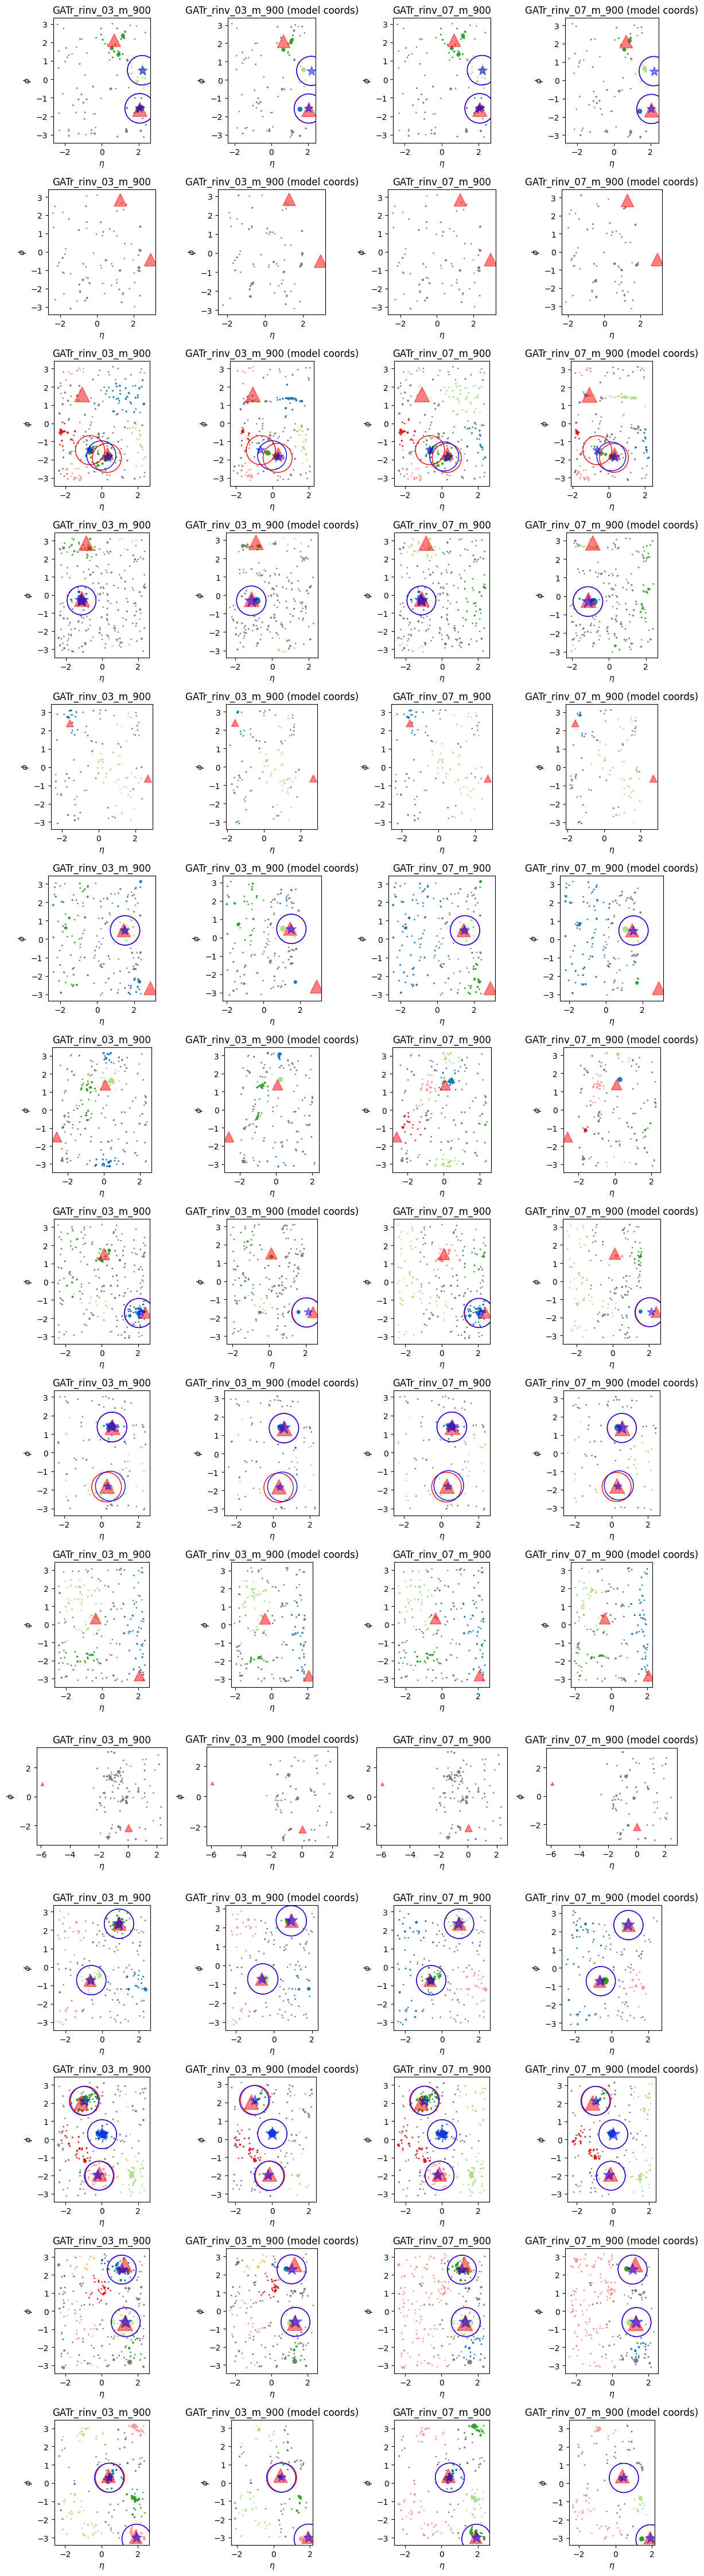

In [15]:
models = {
    "GATr_rinv_03_m_900": "train/Test_betaPt_BC_all_datasets_2025_01_07_17_50_45",
    "GATr_rinv_07_m_900": "train/Test_betaPt_BC_all_datasets_2025_01_08_10_54_58"
}

output_path = get_path("scouting_PFNano_signals2/SVJ_hadronic_std/clustering_model_comparison", "results")

Path(output_path).mkdir(parents=1, exist_ok=1)

sz = 3
n_events_per_file = 15
# len(models) columns, n_events_per_file rows
fig, ax = plt.subplots(n_events_per_file, len(models) * 2, figsize=(len(models)*sz*2, n_events_per_file*sz))
from src.layers.object_cond import calc_eta_phi

for mn, model in enumerate(sorted(models.keys())):
    dataset_path = models[model]
    for ds in range(20):
        filename = get_path(os.path.join(dataset_path, f"eval_{str(ds)}.pkl"), "results")
        clusters_file = get_path(os.path.join(dataset_path, f"clustering_{str(ds)}.pkl"), "results")
        if not os.path.exists(filename):
            continue
        result = CPU_Unpickler(open(filename, "rb")).load()
        print(result["filename"])
        m_med, m_dark, r_inv = get_properties(result["filename"])
        clusters = CPU_Unpickler(open(clusters_file, "rb")).load()
        dataset = EventDataset.from_directory(result["filename"], mmap=True, model_output_file=filename, model_clusters_file=clusters_file)
        for e in range(n_events_per_file):
            c = [colors[i] for i in clusters[result["event_idx"] == e]]
            model_coords = result["pred"][result["event_idx"] == e]
            model_coords = calc_eta_phi(model_coords, 0)
            plot_event(dataset[e], colors=c, ax=ax[e, 2*mn])
            plot_event(dataset[e], colors=c, ax=ax[e, 2*mn+1], custom_coords=model_coords)
            ax[e, 2*mn].set_title(model)
            ax[e, 2*mn + 1].set_title(model + " (model coords)")
        fig.tight_layout()
        fig.savefig(os.path.join(output_path, f"m_med_{m_med}_m_dark_{m_dark}_r_inv_{str(r_inv).replace('.','')}.pdf"))


(700, 20, 0.5)